# Welcome To The Notebook

### Task 1 - Set up the project environment

In [ ]:
!pip install openai==1.7.2 python-dotenv

  Using cached openai-1.7.2-py3-none-any.whl.metadata (17 kB)
Using cached openai-1.7.2-py3-none-any.whl (212 kB)
  Attempting uninstall: openai
    Found existing installation: openai 2.20.0
    Uninstalling openai-2.20.0:
      Successfully uninstalled openai-2.20.0


Importing modules

In [3]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

print("Modules are imported.")

Modules are imported.


In [ ]:
!pip uninstall openai -y
!pip uninstall httpx -y
!pip install openai --upgrade

Found existing installation: openai 2.17.0
Uninstalling openai-2.17.0:
  Successfully uninstalled openai-2.17.0
Found existing installation: httpx 0.28.1
Uninstalling httpx-0.28.1:
  Successfully uninstalled httpx-0.28.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 8.8 MB/s eta 0:00:00


Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

In [7]:
load_dotenv('/content/apikey.env.txt')
APIKEY = os.getenv('APIKEY')

Creating OpenAI Client

In [8]:
client = OpenAI(
    api_key=APIKEY,
)
client

### Task 2 - Prepare the training data

Loading the provided `Customer Complaints.csv`



In [9]:
training_data = pd.read_csv('/content/Customer Complaints.csv')
training_data.head()

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."
2,Phone line always crackling! Can't hear a thi...,"{""Topic"": ""Phone"", ""Problem"": ""Crackling line""..."
3,Ridiculous prices for such terrible service! ...,"{""Topic"": ""Billing"", ""Problem"": ""Overcharged"",..."
4,Internet speed slower than a snail! Can't str...,"{""Topic"": ""Internet"", ""Problem"": ""Slow speed"",..."


**Converting the Complaints records to json**

To be able to use the data for the fine-tuning purpose, we first need to convert each row of the dataframe into the following format:

<pre>
<code>
{
  <span style="color: blue;">"messages"</span>: [
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Providing context about the user's prompt.
                  It may include information about the task,
                  instructions, or background details relevant
                  to the conversation.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">the prompt or input provided by the user,
                  which typically initiates the conversation with the assistant.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">The desired response or output generated by
                  the assistant in response to the user's prompt.</span>"
    }
  ]
}
</code>
</pre>

Let's get started!

Let's define a method that get's a row of the dataframe and convert it into the json format

In [10]:
def save_as_json(row):

  system_content = """
      Given a customer complaint text, extract and return the following information in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two or three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: is a number between 0 and 100 showing
             how angry the customer is about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  with open("training_data.json", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

Now let's use of this method to generate the `training_data.json`

In [11]:
for index, row in training_data.iterrows():
  save_as_json(row)

### Task 3 - Fine-tune GPT 3.5 based on our training data

Let's import the json file we prepared as our training data

In [12]:
data_file = client.files.create(
  file= open("/content/training_data.json", 'rb'),
  purpose='fine-tune',
)
data_file

FileObject(id='file-D9YnX2xRQtUWgh51QQz2Qn', bytes=46722, created_at=1771054075, filename='training_data.json', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

Create the Fine Tuning Job

In [13]:
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file=data_file.id,
    model="gpt-3.5-turbo",
    hyperparameters={
        "n_epochs": 'auto'
    }
)
fine_tuning_job

FineTuningJob(id='ftjob-pnFAH7oeRgd2ygHpccBLeejg', created_at=1771054082, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-ck5jrQf7XGVzB2XmafeeBSDD', result_files=[], seed=2141076140, status='validating_files', trained_tokens=None, training_file='file-D9YnX2xRQtUWgh51QQz2Qn', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None, internal_worker_backend=None)

Let's retrieve the state of the fine-tune

In [16]:
while True:
    time.sleep(2)
    retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
    status = retrieved_job.status
    print(status)

    if status in ["succeeded", "failed", "cancelled"]:
        print(f"Job ended with status: {status}")
        break


succeeded
Job ended with status: succeeded


### Task 4 - Evaluate model

Let's retrieve the event messages to check out the learning process of our fine-tuning job.

In [18]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id = retrieved_job.id, limit=100).data)
for e in events:
  print(e.message)

The job has successfully completed
Usage policy evaluations completed, model is now enabled for sampling
Moderation checks for snapshot ft:gpt-3.5-turbo-0125:personal::D94UpUs9 passed.
Evaluating model against our usage policies
New fine-tuned model created
Checkpoint created at step 134
Checkpoint created at step 67
Step 201/201: training loss=0.06
Step 200/201: training loss=0.03
Step 199/201: training loss=0.03
Step 198/201: training loss=0.00
Step 197/201: training loss=0.05
Step 196/201: training loss=0.00
Step 195/201: training loss=0.02
Step 194/201: training loss=0.04
Step 193/201: training loss=0.04
Step 192/201: training loss=0.10
Step 191/201: training loss=0.13
Step 190/201: training loss=0.00
Step 189/201: training loss=0.03
Step 188/201: training loss=0.03
Step 187/201: training loss=0.00
Step 186/201: training loss=0.02
Step 185/201: training loss=0.00
Step 184/201: training loss=0.04
Step 183/201: training loss=0.11
Step 182/201: training loss=0.02
Step 181/201: trainin

Let's extract the training loss in each learning step

In [25]:
steps = []
train_loss = []

for e in events:
    if e.data and 'train_loss' in e.data:
        steps.append(e.data['step'])
        train_loss.append(e.data['train_loss'])

print(steps)
print(train_loss)


[201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109]
[0.06109039857983589, 0.033163756132125854, 0.03260231018066406, 6.499114078906132e-06, 0.045883405953645706, 0.0005501641426235437, 0.017421942204236984, 0.04228172451257706, 0.037731245160102844, 0.0959637239575386, 0.13056617975234985, 7.276181804627413e-06, 0.027373580262064934, 0.02783203125, 1.038445407175459e-05, 0.023498687893152237, 1.3210154975240584e-05, 0.041390858590602875, 0.10648037493228912, 0.023175302892923355, 0.027828751131892204, 0.027617454528808594, 0.06387370079755783, 0.14523224532604218, 0.0342587381601

Use a line chart to visualize the train_loss in each step

Text(0, 0.5, 'Train Loss')

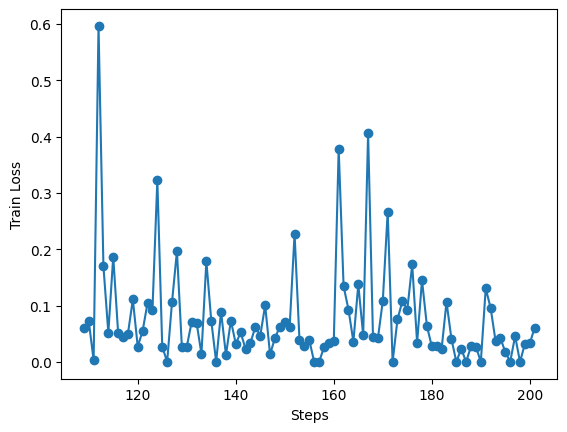

In [26]:
plt.plot(steps, train_loss, marker = 'o', linestyle = '-')
plt.xlabel('Steps')
plt.ylabel('Train Loss')

### Task 5 - Deploy our model

Let's take a look at `retrieved_job` again

In [27]:
myLLM= retrieved_job.fine_tuned_model
print(myLLM)

ft:gpt-3.5-turbo-0125:personal::D94UpUs9


Defining a method to extract information from a given user complaint using a specific LLM and return the results.

In [28]:
def extract_details(user_complaint, model_name):
    """
    This function extracts information from a given user complaint using a specific LLM (Large Language Model).

    Parameters:
    user_complaint (str): The text of the user's complaint.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given a customer complaint text, extract and return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content


Let's use our fine-tuned model to extract the details for the following user complaint:

*TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!*

In [29]:
complaint = "TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!"
extract_details(complaint, myLLM)

'{"Topic": "TV", "Problem": "Channels disappearing", "Customer_Dissatisfaction_Index": 95}'

Let's test our `GPT-4` model with the same user complaint

In [30]:
from numpy import extract
extract_details(complaint, 'gpt-4')

'{\n    "Topic": "TV Subscription",\n    "Problem": "TV channels disappearing from subscription",\n    "Customer_Dissatisfaction_Index": "High"\n}'

Let's try for the following complaint:

*Line is down! It is really annoying!*

In [31]:
complaint = "Line is down! It is really annoying!"
extract_details(complaint, myLLM)

'{"Topic": "Internet", "Problem": "Line down", "Customer_Dissatisfaction_Index": 10}'

Now let's compare the results from GPT-4

In [32]:
extract_details(complaint, 'gpt-4')

'{\n    "Topic": "Line Down",\n    "Problem": "The customer\'s line is down and causing annoyance",\n    "Customer_Dissatisfaction_Index": "High"\n}'

We can see that our model, which is trained on our dataset, provides better answers compared to GPT-4. Our model is fine-tuned based on our data and is familiar with the different edge cases and the context of our dataset.

In [33]:
customer_complaint = "I am very Angry! I want my money back!"
extract_details(customer_complaint, myLLM)

'{"Topic": "Refund", "Problem": "Request for refund", "Customer_Dissatisfaction_Index": 10}'